In [1]:
import copy
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy.random as rnd
import tsplib95
import tsplib95.distances as distances

from alns import ALNS, State
from alns.accept import HillClimbing
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

In [2]:
%matplotlib inline

In [3]:
SEED = 5432

# The travelling salesman problem

The travelling salesman problem (TSP) is a classic problem in operations research. It asks how to construct the minimum distance tour between a number of nodes, such that each node is visited once and the tour concludes at the starting city (that is, it forms a cycle). It is perhaps the best-known problem in the class of [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) problems.

## Data
There are a considerable number of test data sets available for the TSP, varying in size from a hundred or so locations to many hundreds of thousands. For the sake of exposition, we shall use one of the smaller data sets: the data from the XQF131 VLSI instance, made available [here](http://www.math.uwaterloo.ca/tsp/vlsi/index.html#XQF131). It consists of 'only' 131 nodes, with an optimal tour length of 564.

In [4]:
data = tsplib95.load('xqf131.tsp')

# These we will use in our representation of a TSP problem: a list of
# (city, coord)-tuples.
cities = [(city, tuple(coord)) for city, coord in data.node_coords.items()]

solution = tsplib95.load('xqf131.opt.tour')
optimal = data.trace_tours(solution.tours)[0]

print(f"Total optimal tour length is {optimal}.")

Total optimal tour length is 564.


In [5]:
def draw_graph(graph, only_nodes=False):
    """
    Helper method for drawing TSP (tour) graphs.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    if only_nodes:
        nx.draw_networkx_nodes(graph, data.node_coords, node_size=25, ax=ax)
    else:
        nx.draw_networkx(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

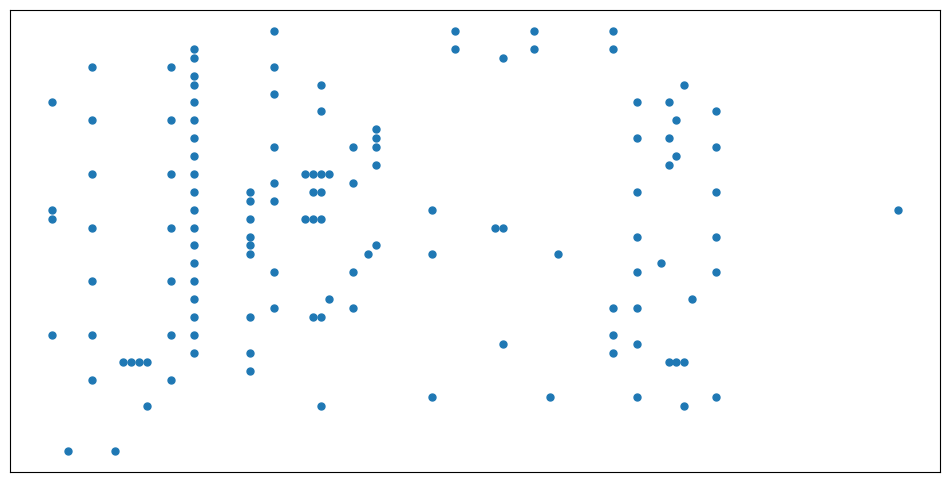

In [6]:
draw_graph(data.get_graph(), only_nodes=True)

To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class ``State`` to describe a solution, with an ``objective()`` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## Solution state

In [7]:
class TspState(State):
    """
    Solution class for the TSP problem. It has two data members, nodes, and edges.
    nodes is a list of node tuples: (id, coords). The edges data member, then, is
    a mapping from each node to their only outgoing node.
    """

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def objective(self):
        """
        The objective function is simply the sum of all individual edge lengths,
        using the rounded Euclidean norm.
        """
        return sum(distances.euclidean(node[1], self.edges[node][1])
                   for node in self.nodes)
    
    def to_graph(self):
        """
        NetworkX helper method.
        """
        graph = nx.Graph()

        for node, coord in self.nodes:
            graph.add_node(node, pos=coord)

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from[0], node_to[0])

        return graph

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider three destroy operators: **worst removal**, **path removal** and **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [8]:
degree_of_destruction = 0.25

def edges_to_remove(state):
    return int(len(state.edges) * degree_of_destruction)

In [9]:
def worst_removal(current, rnd_state):
    """
    Worst removal iteratively removes the 'worst' edges, that is,
    those edges that have the largest distance.
    """
    destroyed = copy.deepcopy(current)

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: distances.euclidean(node[1],
                                                              destroyed.edges[node][1]))

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-(idx + 1)]]

    return destroyed

In [10]:
def path_removal(current, rnd_state):
    """
    Removes an entire consecutive sub-path, that is, a series of
    contiguous edges.
    """
    destroyed = copy.deepcopy(current)
    
    node_idx = rnd_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed

In [11]:
def random_removal(current, rnd_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = copy.deepcopy(current)
    
    for idx in rnd_state.choice(len(destroyed.nodes),
                                edges_to_remove(current),
                                replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed

## Repair operators

We implement a simple, **greedy repair** strategy. It determines a set of nodes that are currently not visited, and then links these up to the tour such that it forms one cycle.

In [12]:
def would_form_subcycle(from_node, to_node, state):
    """
    Ensures the proposed solution would not result in a cycle smaller
    than the entire set of nodes. Notice the offsets: we do not count
    the current node under consideration, as it cannot yet be part of
    a cycle.
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False

In [13]:
def greedy_repair(current, rnd_state):
    """
    Greedily repairs a tour, stitching up nodes that are not departed
    with those not visited.
    """
    visited = set(current.edges.values())
  
    # This kind of randomness ensures we do not cycle between the same
    # destroy and repair steps every time.
    shuffled_idcs = rnd_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)

        # Computes all nodes that have not currently been visited,
        # that is, those that this node might visit. This should
        # not result in a subcycle, as that would violate the TSP
        # constraints.
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # Closest visitable node.
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)

    return current

## Initial solution

In [14]:
random_state = rnd.RandomState(SEED)
state = TspState(cities, {})

init_sol = greedy_repair(state, random_state)
print(f"Initial solution objective is {init_sol.objective()}.")

Initial solution objective is 796.


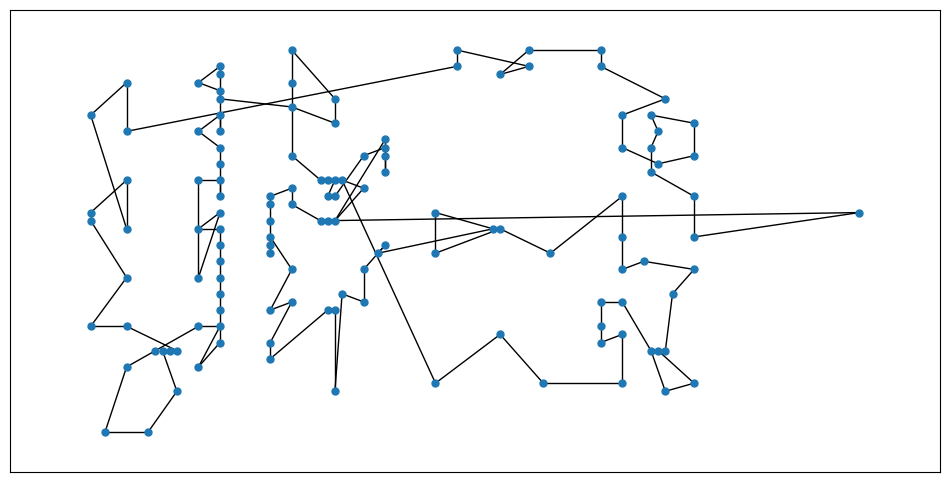

In [15]:
draw_graph(init_sol.to_graph())

## Heuristic solution

Here we perform the ALNS procedure. The heuristic is given 60 seconds of runtime.

In [16]:
alns = ALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [17]:
criterion = HillClimbing()
scheme = RouletteWheel([3, 2, 1, 0.5], 3, 1, 0.8)
stop = MaxRuntime(60)

result = alns.iterate(init_sol, scheme, criterion, stop)

In [18]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - optimal) / optimal

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {optimal}.")

Best heuristic objective is 607.
This is 7.6% worse than the optimal solution, which is 564.


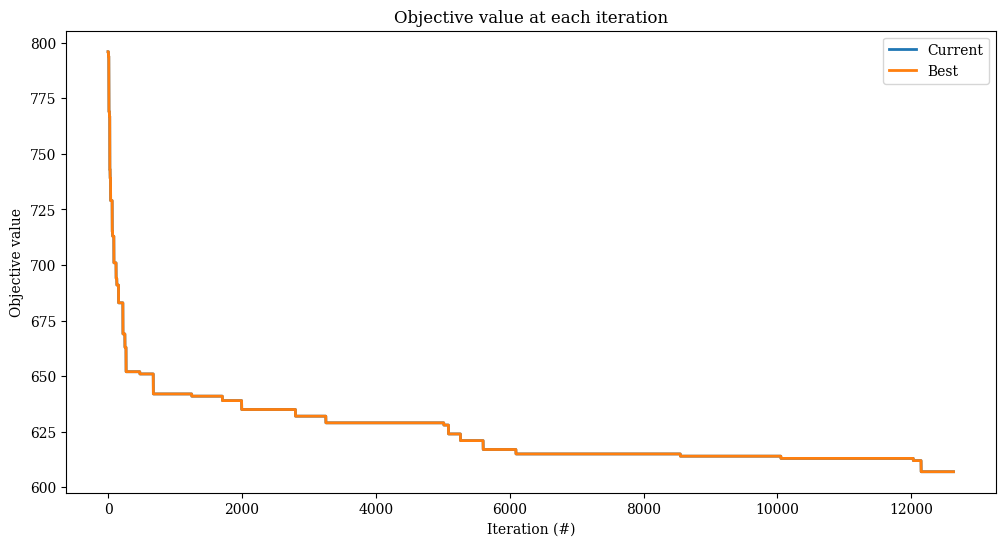

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax, lw=2)

Let's have a look at the solution:

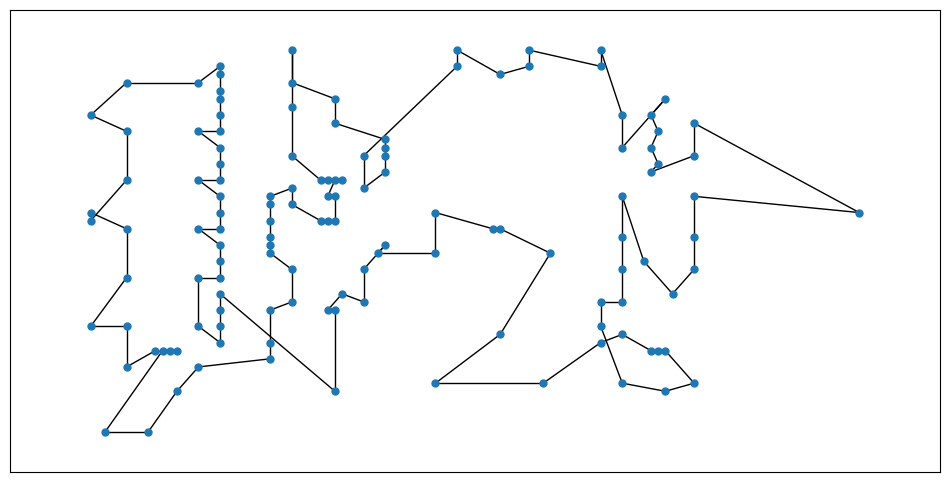

In [20]:
draw_graph(solution.to_graph())

## Post-processing

It is not difficult to see that the above solution can easily be improved upon: there are plenty of inefficiencies in small subpaths near both the center and the various corners of the tour. We will partially remedy this with a single pass over all nodes, optimally choosing a subpath of length ``k`` starting at each of these nodes. Since such a process is computationally demanding, we select ``k = 7``.

In [21]:
k = 7

In [22]:
def optimal_sub_path(nodes, start_node, end_node):
    """
    Computes the minimum cost sub-path from the given nodes,
    where the sub-path is fixed at start_node and end_node.
    """

    def fix_bounds(permutation):
        return (start_node,) + permutation + (end_node,)

    def cost(sub_path):
        path = fix_bounds(sub_path)
        return sum(distances.euclidean(path[idx][1], path[idx + 1][1])
                   for idx in range(len(path) - 1))

    opt_path = min(itertools.permutations(nodes, k), key=cost)
    return fix_bounds(opt_path)

In [23]:
def post_process(state):
    """
    For each node in the passed-in state, this post-processing step
    computes the optimal sub-path of the next k nodes. The run-time
    complexity is about O(n * k!), with n the number of nodes.
    """
    state = copy.deepcopy(state)

    for start_node in state.nodes:
        nodes = []
        node = start_node

        # Determine the next k nodes that make up the sub-path starting
        # at this start_node.
        for _ in range(k):
            node = state.edges[node]
            nodes.append(node)

        end_node = state.edges[node]
        opt_path = optimal_sub_path(nodes, start_node, end_node)

        # Replace the existing path with the optimal sub-path.
        for first, second in zip(opt_path, opt_path[1:]):
            state.edges[first] = second

    return state

In [24]:
new_solution = post_process(solution)
new_objective = new_solution.objective()
pct_difference = 100 * (new_objective - optimal) / optimal

print(f"New heuristic objective is {new_objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {optimal}.")

New heuristic objective is 578.
This is 2.5% worse than the optimal solution, which is 564.


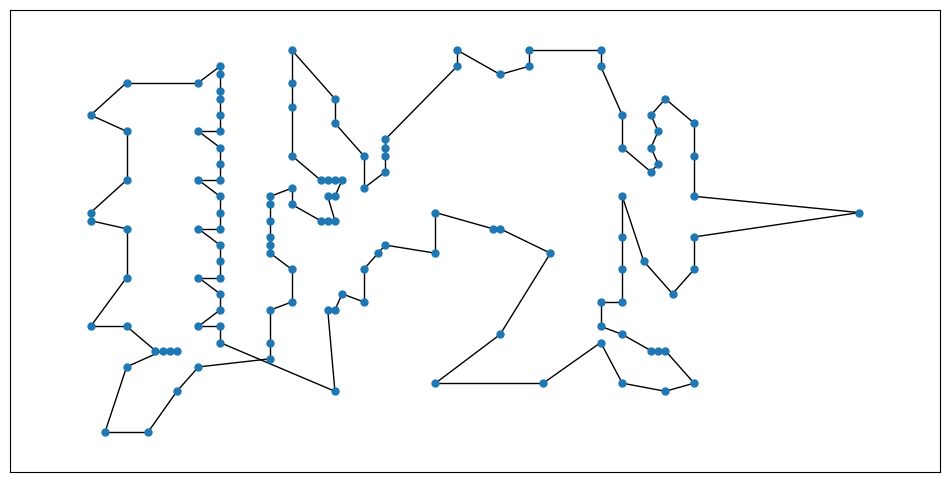

In [25]:
draw_graph(new_solution.to_graph())

## Conclusions

In the code above we implemented a very simple heuristic for the TSP, using the ALNS meta-heuristic framework. We did not tinker too much with the various hyperparameters available on the ALNS implementation, but even for these relatively basic heuristic methods and workflow we find a very good result - just 2% worse than the optimal tour.

This notebook showcases how the ALNS library may be put to use to construct powerful, efficient heuristic pipelines from simple, locally greedy operators.